In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import functional
from torch.utils.data import DataLoader
from torch.nn import Sequential
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform_shifted = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: functional.affine(x,angle=0.0,translate=(20,20),scale=1.0,shear=0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform_flip = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: functional.hflip(x)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform_rotated = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: functional.rotate(x,45)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.OxfordIIITPet(root='./dataF',split='trainval',target_types='category',transform=train_transform,download=False)
train_loader = DataLoader(train_dataset,batch_size=64,num_workers=2)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

alexNet = models.alexnet(pretrained=True).to(device)
for param in alexNet.parameters():
    param.requires_grad = False

feature_extractor = Sequential(*list(alexNet.classifier.children())[:-1])

/home/shwetank/Desktop/ShwetankAssignmentMT2025725/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shwetank/Desktop/ShwetankAssignmentMT2025725/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def extract_feature(loader):
    features,labels = [],[]
    for imgs,lbls in tqdm(loader):
        imgs = imgs.to(device)
        x = alexNet.features(imgs)
        x = alexNet.avgpool(x)
        x = torch.flatten(x,1)
        x = feature_extractor(x)
        features.append(x.cpu())
        labels.append(lbls.cpu())
    return torch.cat(features),torch.cat(labels)

In [17]:
X_train, y_train = extract_feature(train_loader)
X_train = X_train.numpy()
y_train = y_train.numpy()

100%|██████████| 58/58 [00:11<00:00,  4.89it/s]


In [ ]:
test_dataset_baseline = datasets.OxfordIIITPet(root='./dataF',split='test',target_types='category',transform=test_transform,download=False)
test_loader_baseline = DataLoader(test_dataset_baseline, batch_size=64, num_workers=2)

test_dataset_shifted = datasets.OxfordIIITPet(root='./dataF',split='test',target_types='category',transform=test_transform_shifted,download=False)
test_loader_shifted = DataLoader(test_dataset_shifted,shuffle=False,batch_size=64,num_workers=2)

test_dataset_flip = datasets.OxfordIIITPet(root='./dataF',split='test',target_types='category',transform=test_transform_flip,download=False)
test_loader_flip = DataLoader(test_dataset_flip,shuffle=False,batch_size=64,num_workers=2)

test_dataset_rotated = datasets.OxfordIIITPet(root='./dataF',split='test',target_types='category',transform=test_transform_rotated,download=False)
test_loader_rotated = DataLoader(test_dataset_rotated,shuffle=False,batch_size=64,num_workers=2)

X_test_baseline, y_test_baseline = extract_feature(test_loader_baseline)
X_test_shifted, y_test_shifted = extract_feature(test_loader_shifted)
X_test_flip, y_test_flip = extract_feature(test_loader_flip)
X_test_rotated, y_test_rotated = extract_feature(test_loader_rotated)

100%|██████████| 58/58 [00:11<00:00,  5.17it/s]


In [ ]:

X_test_baseline_np, y_test_baseline_np = X_test_baseline.numpy(), y_test_baseline.numpy()
X_test_shifted_np, y_test_shifted_np = X_test_shifted.numpy(), y_test_shifted.numpy()
X_test_flip_np, y_test_flip_np = X_test_flip.numpy(), y_test_flip.numpy()
X_test_rotated_np, y_test_rotated_np = X_test_rotated.numpy(), y_test_rotated.numpy()

# --- Train classifier on frozen AlexNet features ---
clf_logreg = LogisticRegression(max_iter=1000)
clf_logreg.fit(X_train, y_train)  # X_train and y_train from our feature extraction

# --- Now we can evaluate on all test sets ---
pred_baseline = clf_logreg.predict(X_test_baseline_np)
acc_baseline = accuracy_score(y_test_baseline_np, pred_baseline)
print("Baseline Test Accuracy:", acc_baseline)

pred_shifted = clf_logreg.predict(X_test_shifted_np)
acc_shifted = accuracy_score(y_test_shifted_np, pred_shifted)
print("Shifted Test Accuracy:", acc_shifted)

pred_flip = clf_logreg.predict(X_test_flip_np)
acc_flip = accuracy_score(y_test_flip_np, pred_flip)
print("Flipped Test Accuracy:", acc_flip)

pred_rotated = clf_logreg.predict(X_test_rotated_np)
acc_rotated = accuracy_score(y_test_rotated_np, pred_rotated)
print("Rotated Test Accuracy:", acc_rotated)

Baseline Test Accuracy: 0.7192695557372581
Shifted Test Accuracy: 0.7105478331970564
Flipped Test Accuracy: 0.7176342327609703
Rotated Test Accuracy: 0.4657944944126465


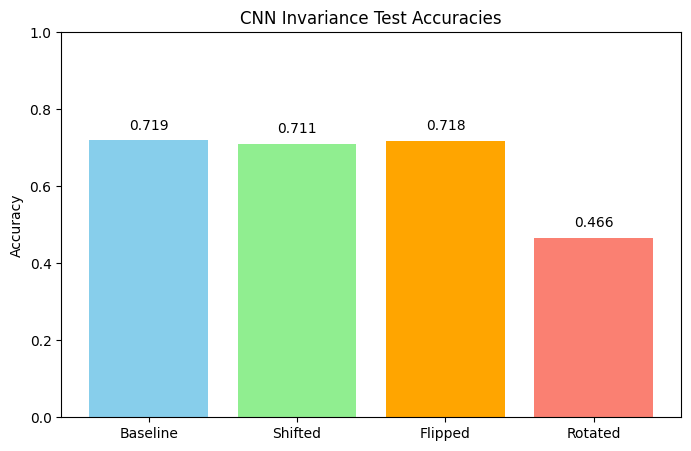

In [ ]:
import matplotlib.pyplot as plt


acc_values = [acc_baseline, acc_shifted, acc_flip, acc_rotated]
labels = ['Baseline', 'Shifted', 'Flipped', 'Rotated']

plt.figure(figsize=(8,5))
bars = plt.bar(labels, acc_values, color=['skyblue', 'lightgreen', 'orange', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('CNN Invariance Test Accuracies')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.3f}', ha='center', va='bottom')

plt.show()

Shifting and Flipping(Horizontal) are invariant but Rotation is not invariant